In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing the data

In [ ]:
# Path to the ZIP dataset file
dataset_path = '/content/drive/MyDrive/archive.zip'

In [ ]:
!ls /content/drive

MyDrive


In [ ]:
# Extract the ZIP file to a specific directory
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/archive.zip'

extract_to_path = '/content/drive/MyDrive/brain_tumor_object_detection/data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("Extraction complete. Files are extracted to:", extract_to_path)

Extraction complete. Files are extracted to: /content/drive/MyDrive/brain_tumor_object_detection/data


In [ ]:
#check the unziped images
import os

extracted_folder_path = '/content/drive/MyDrive/brain_tumor_object_detection/data'

extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)


['Brain Tumor labeled dataset']


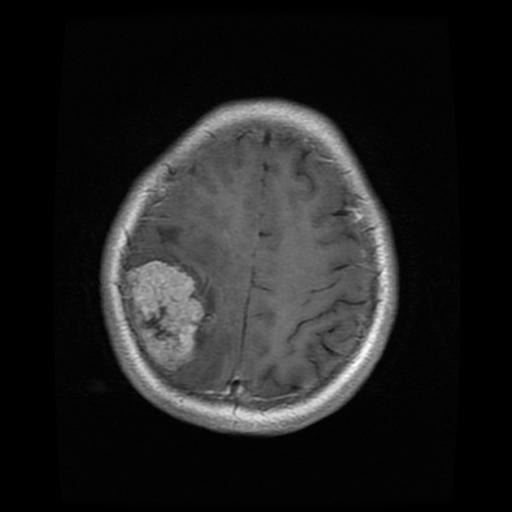

In [ ]:
#show a pic from dataset
sample_image = Image.open('/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/meningioma/Tr-me_0011.jpg')
sample_image

In [ ]:
# Install necessary packages for data augmentation and YOLOv8
!pip install Augmentor
!pip install ultralytics

In [ ]:
# Load the data and annotations from the dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

In [ ]:
#dataset image size
sample_image.size

(512, 512)

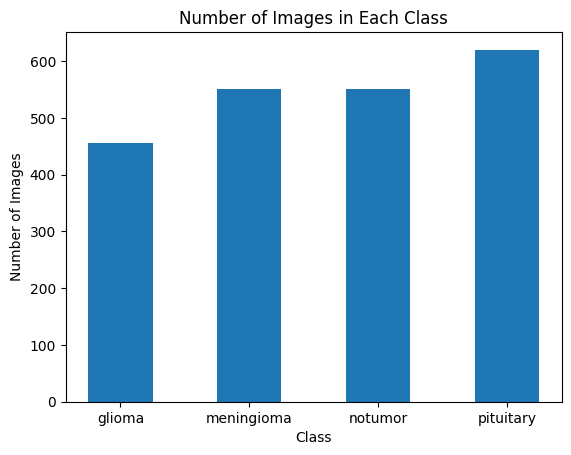

In [ ]:
#image charts with number of them
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

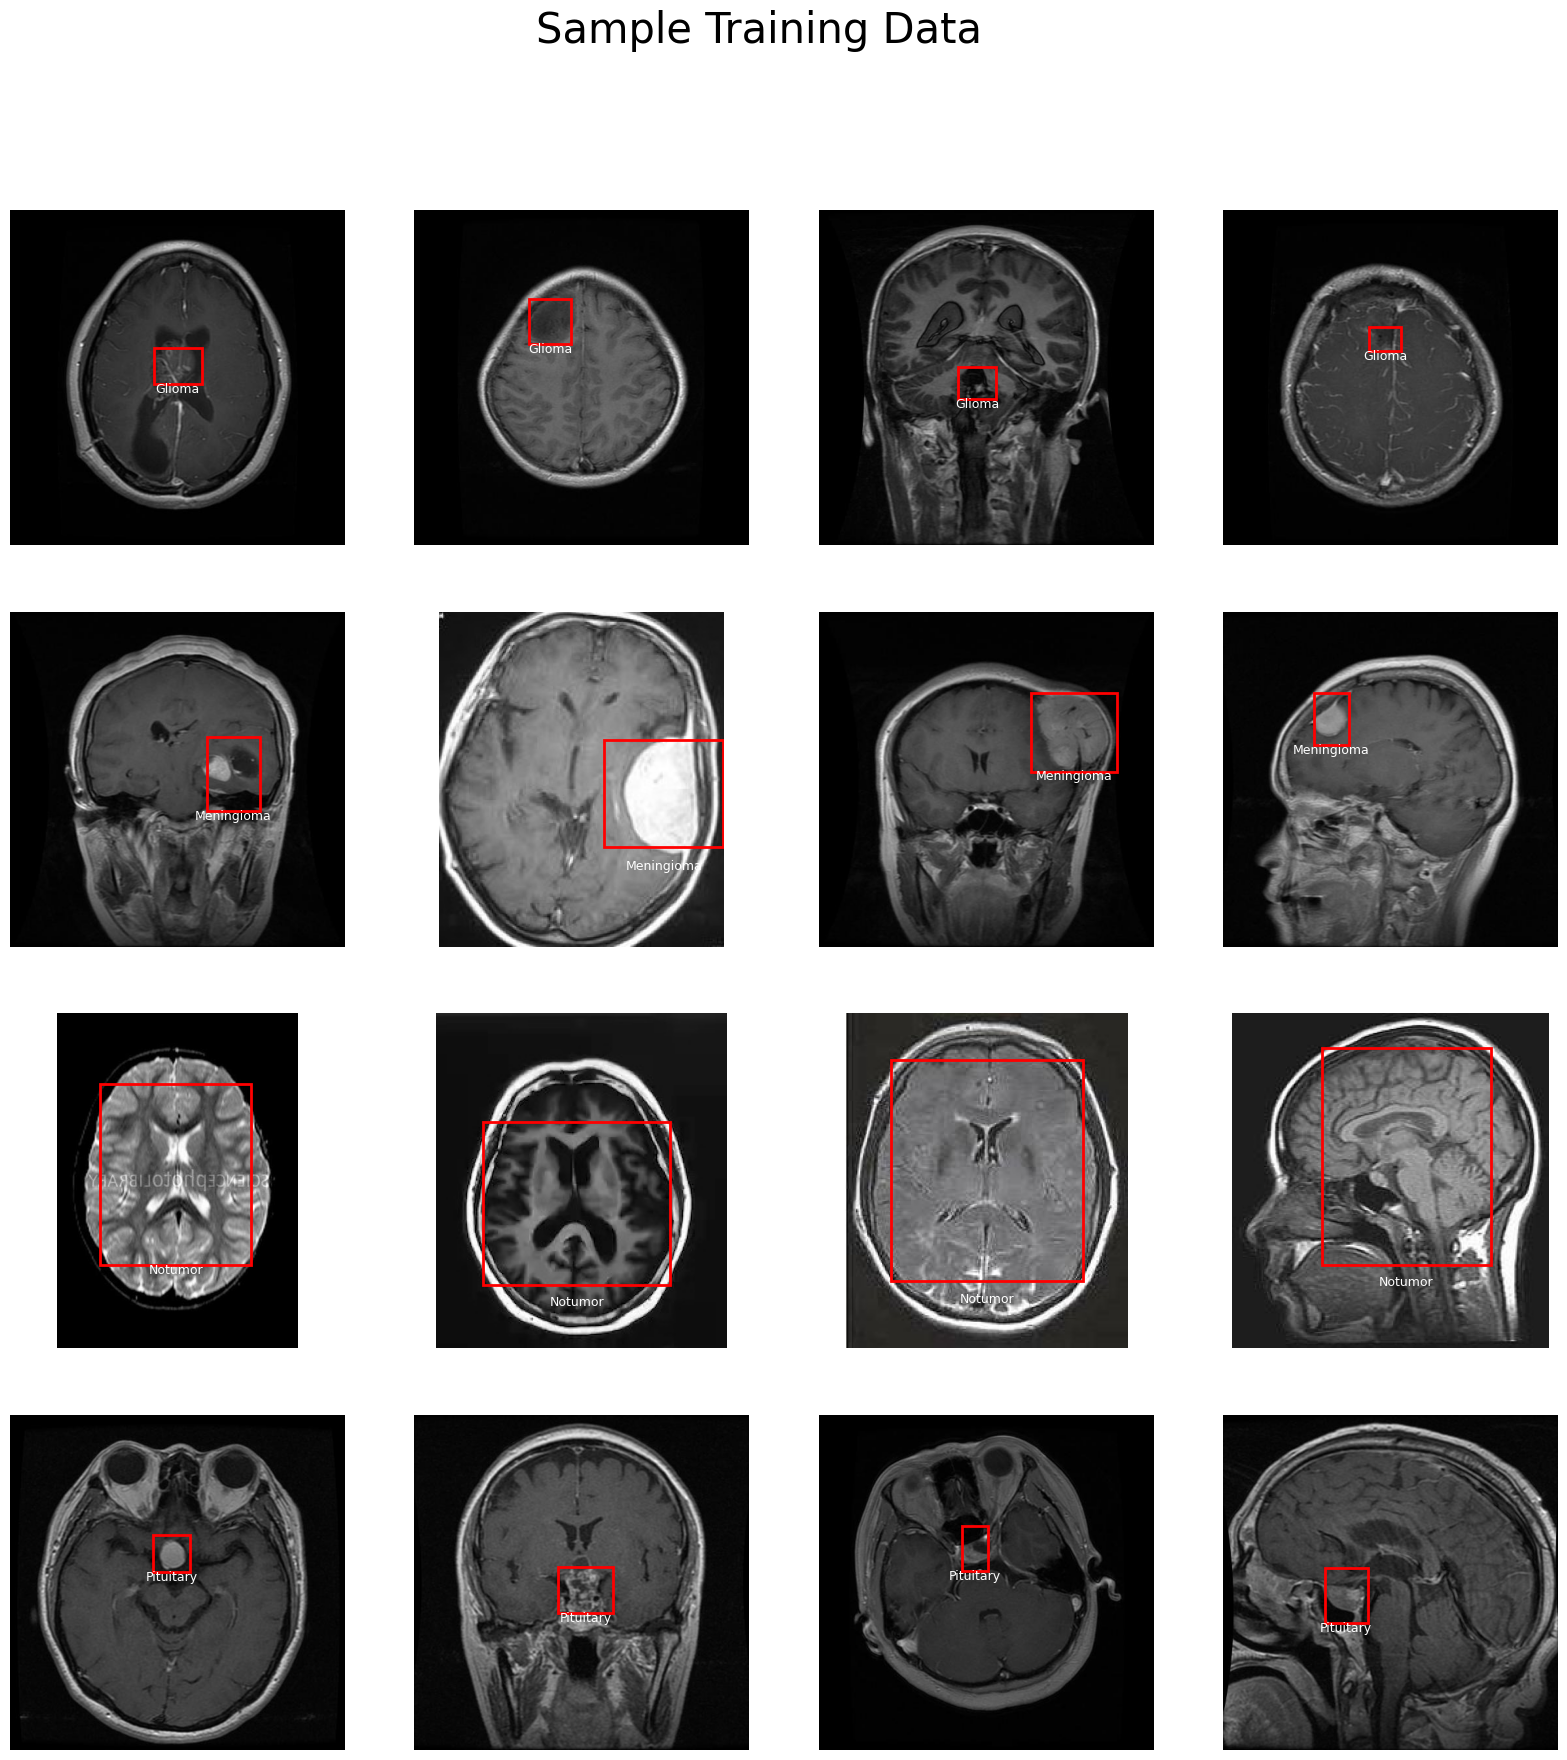

In [ ]:
# Set up the dataset directory and class labels
dataset_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# Set up the plot
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Loop through each class label and corresponding axis row
for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)    # Set the directory for the current class's images
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]    # Get a list of all jpg files in the class directory
    selected_images = random.sample(image_files, 4)    # Select 4 random images from the class directory

    # Loop through each selected image and axis to plot
    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt')) # Get the annotation file for the image
        with open(annotation_file, 'r') as file:   # Read the annotation file to get the bounding box details
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        # Read the image
        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        # Calculate the bounding box coordinates based on the normalized center and size
        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')        # Create a rectangle patch for the bounding box
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

# Split dataset

In [ ]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    # Set a default random seed if not provided
    random_seed = random_seed or 42

    # Get a list of class directories in the dataset directory
    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    # Create 'train' and 'test' directories if they don't already exist
    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    # Loop over each class directory
    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        # Get all image files in the current class directory
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        # Skip the class if there are not enough images to split
        if len(image_files) < min_samples_per_class:
            continue

        # Perform stratified train-test split on the image files
        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        # Move train images and their corresponding annotations to the 'train' directory
        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image) # Define paths for source image and annotation files
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)# Define destination paths in the 'train' directory
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)# Create destination directories if they don't exist

            # Move the image and annotation files to the 'train' directory
            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        # Move test images and their corresponding annotations to the 'test' directory
        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            # Move the image and annotation files to the 'test' directory
            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

In [ ]:
# Example usage of the function
dataset_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

#showing the result of split in chart

In [ ]:
#count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):    # Iterate through each subdirectory (class) in the dataset directory
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):        # Check if the current item is a directory (class)
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')]) # Count the number of '.jpg' files in the class directory and store it in the dictionary
    return class_counts

In [ ]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

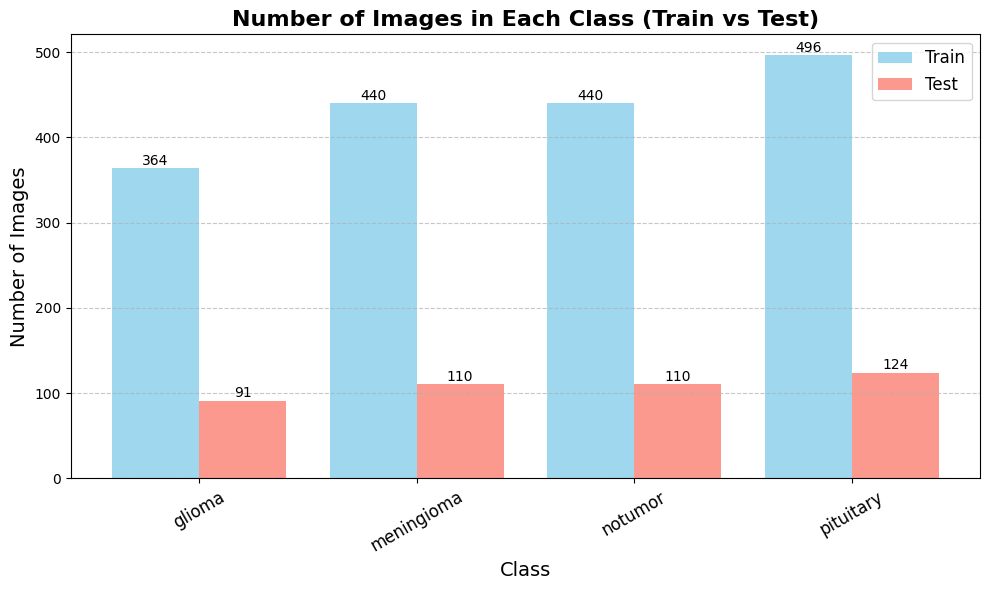

In [ ]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets with improved visualization.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.4
    index = range(len(class_names))

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 6))
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train', color='skyblue', alpha=0.8)
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test', color='salmon', alpha=0.8)

    # Adding values on top of bars
    for bar in bar1:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)
    for bar in bar2:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

    # Setting labels and title
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('Number of Images', fontsize=14)
    ax.set_title('Number of Images in Each Class (Train vs Test)', fontsize=16, fontweight='bold')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(class_names, rotation=30, fontsize=12)
    ax.legend(fontsize=12)

    # Adding grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjusting layout
    plt.tight_layout()
    plt.show()

# Example usage:
train_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train'
test_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test'

plot_image_counts(train_directory, test_directory)


# Create YML

In [ ]:

yaml_content = """
train: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train
val: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test

nc: 4
names: ['pituitary', 'notumor', 'glioma', 'meningioma']
"""

yaml_path = '/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml'

with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"YAML file created successfully at {yaml_path}")


YAML file created successfully at /content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml


In [ ]:
#make sure that YML file created
import os

yaml_path = '/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml'
if os.path.exists(yaml_path):
    print("File exists!")
else:
    print("File does not exist!")


File exists!


In [ ]:
# Load the YOLOv8 model with the configuration file 'yolov8n.yaml' (a smaller variant of YOLOv8)
yolo_btd_model = YOLO('yolov8n.yaml')

# Train the YOLO model with the brain tumor dataset using the configuration specified in 'brain_tumor_dataset.yaml'
# The model will be trained for 10 epochs
yolo_btd_model_results = yolo_btd_model.train(data='/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml', epochs=10)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

100%|██████████| 755k/755k [00:00<00:00, 86.4MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 261MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train/glioma... 1740 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1740/1740 [00:18<00:00, 92.04it/s] 


train: New cache created: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train/glioma.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma... 435 images, 0 backgrounds, 0 corrupt: 100%|██████████| 435/435 [00:06<00:00, 64.10it/s] 


val: New cache created: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.2G      2.947      5.446      4.071         12        640: 100%|██████████| 109/109 [00:47<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]

                   all        435        439   0.000884      0.259    0.00257   0.000698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.14G      2.452      4.538       3.25         12        640: 100%|██████████| 109/109 [00:45<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]

                   all        435        439      0.365       0.29     0.0741     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.22G      2.255      3.581      2.814         12        640: 100%|██████████| 109/109 [00:42<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]


                   all        435        439       0.56      0.296      0.264      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.14G      2.102      2.743      2.604         12        640: 100%|██████████| 109/109 [00:42<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


                   all        435        439      0.675      0.431      0.478       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.22G       1.95      2.259      2.436         13        640: 100%|██████████| 109/109 [00:42<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]

                   all        435        439      0.568      0.593      0.573      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.14G      1.855      2.014      2.343         12        640: 100%|██████████| 109/109 [00:41<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


                   all        435        439      0.639      0.605      0.652       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.14G      1.794      1.811      2.261         13        640: 100%|██████████| 109/109 [00:42<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


                   all        435        439      0.629      0.607      0.671      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.14G       1.74      1.661      2.222         12        640: 100%|██████████| 109/109 [00:40<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


                   all        435        439      0.717      0.663      0.736      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.22G      1.667      1.536      2.152         13        640: 100%|██████████| 109/109 [00:44<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        435        439      0.753      0.694      0.766      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.14G      1.633      1.431      2.114         12        640: 100%|██████████| 109/109 [00:41<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]

                   all        435        439      0.757      0.725      0.786      0.427



10 epochs completed in 0.142 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.01it/s]


                   all        435        439      0.757      0.725      0.786      0.427
             pituitary        124        125      0.822      0.849      0.887       0.39
               notumor        110        110      0.774      0.874      0.864      0.475
                glioma         91         94      0.655      0.287      0.467      0.187
            meningioma        110        110      0.777      0.891      0.925      0.654
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
# Specify the path to the directory containing the model training results
import os

path = '/content/runs/detect/train2/'
print("Files in directory:", os.listdir(path))# List and print all the files and directories within the specified path


Files in directory: ['args.yaml', 'val_batch1_pred.jpg', 'labels_correlogram.jpg', 'PR_curve.png', 'results.csv', 'R_curve.png', 'events.out.tfevents.1735312416.1bc55124828a.328.0', 'train_batch1.jpg', 'labels.jpg', 'results.png', 'P_curve.png', 'weights', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg', 'train_batch0.jpg', 'confusion_matrix_normalized.png', 'val_batch2_labels.jpg', 'val_batch1_labels.jpg', 'train_batch2.jpg', 'val_batch2_pred.jpg', 'F1_curve.png', 'confusion_matrix.png']


# Result of training

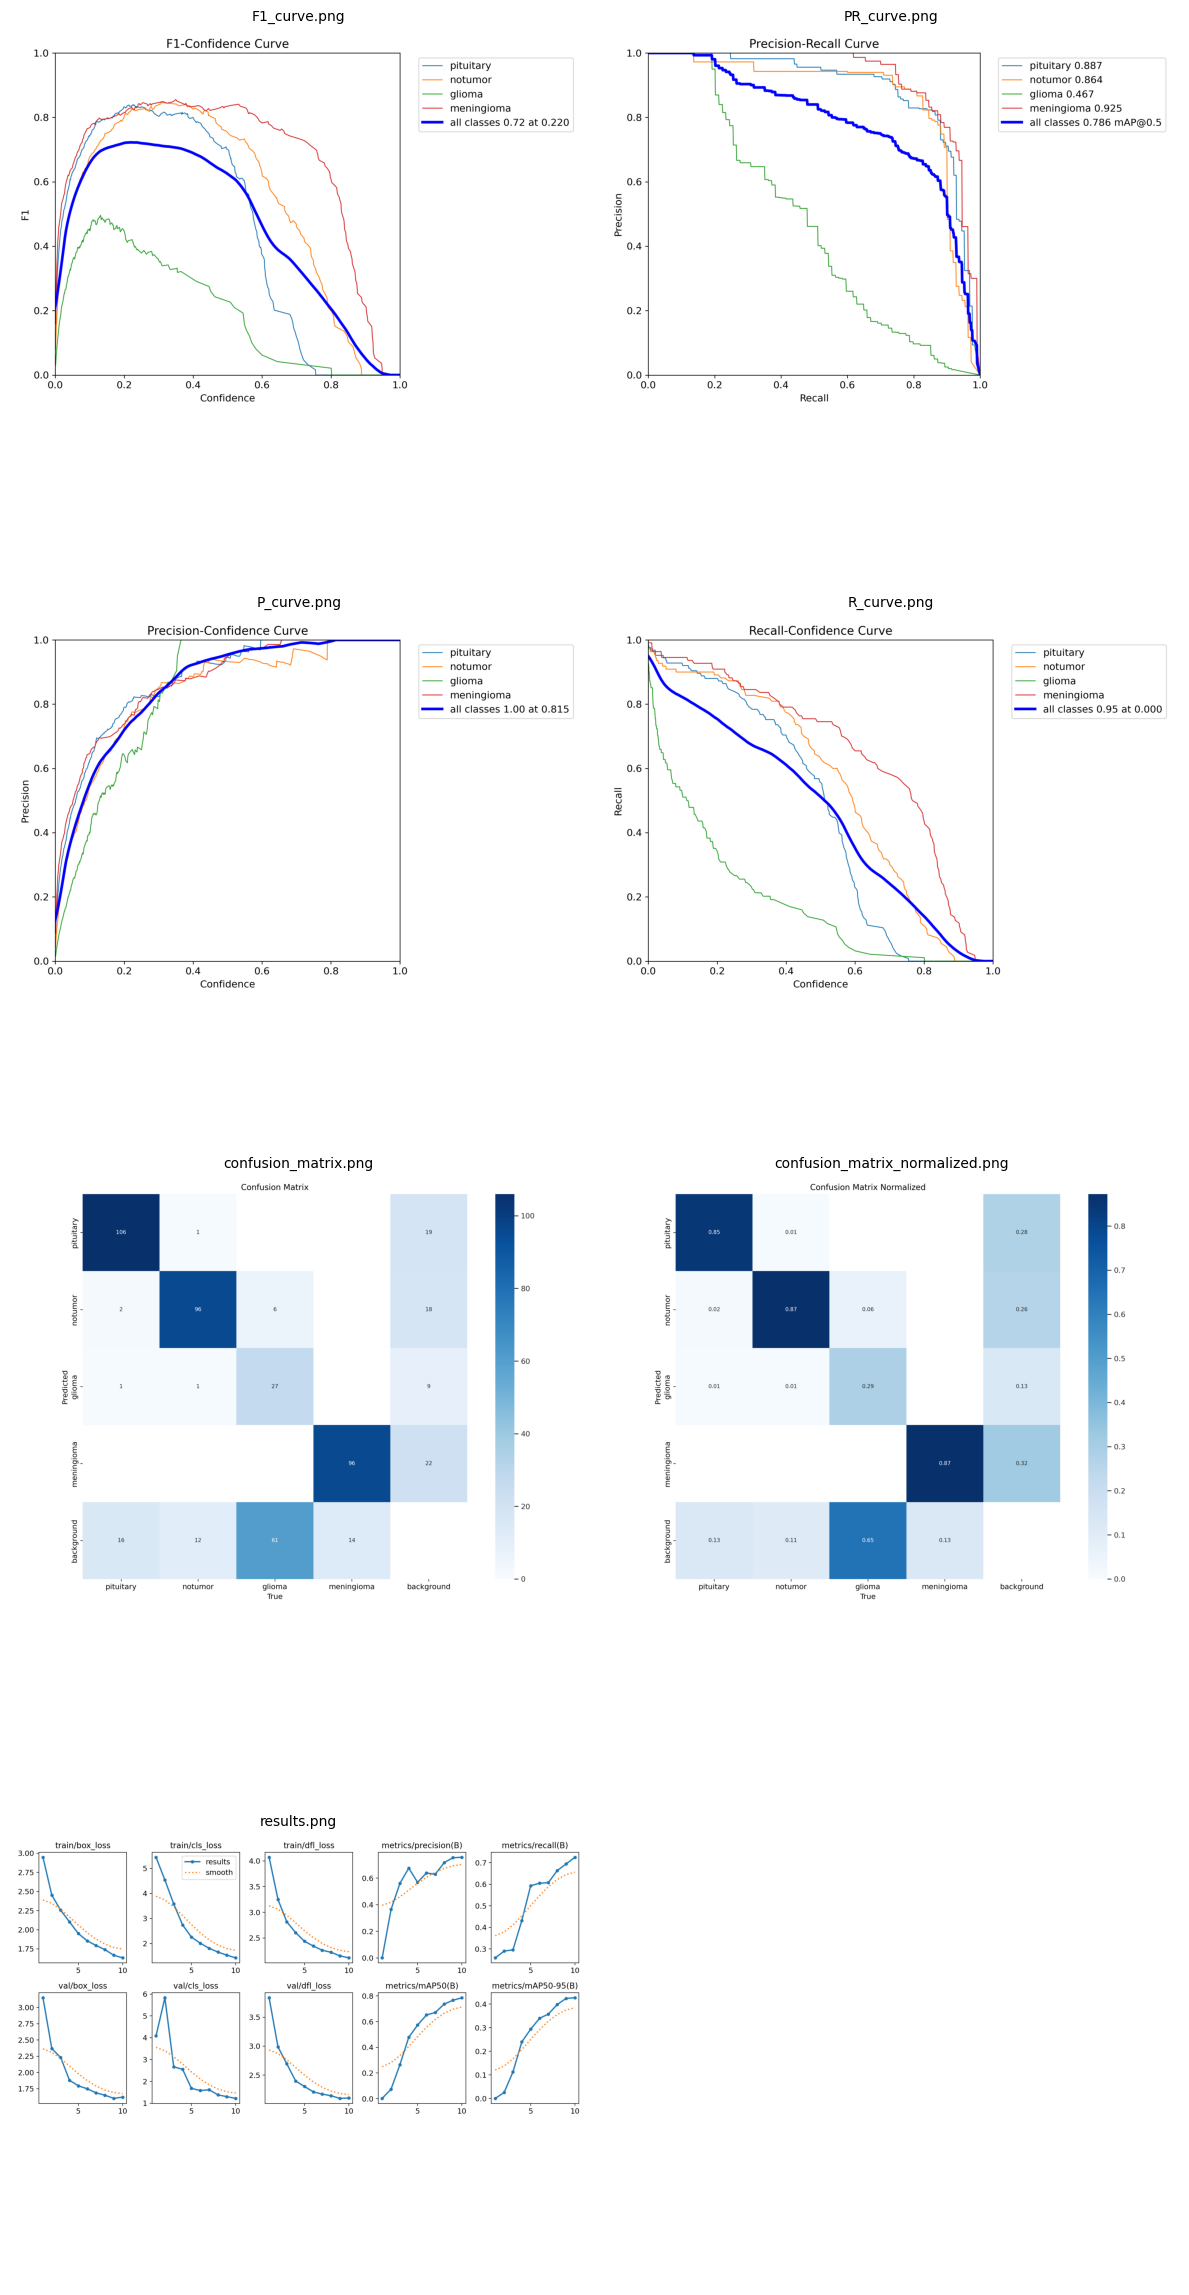

In [ ]:
#Calculate the number of rows required based on the total images and columns
def plot_images(image_paths, columns=2):
    rows = math.ceil(len(image_paths) / columns)
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 6, rows * 6))# Create subplots with the calculated number of rows and columns
    axes = axes.flatten()  # Flatten the axes for easier iteration

    # Loop through the axes and the provided image paths
    for i, ax in enumerate(axes):
        if i < len(image_paths): # Check if there are more images to display
            image_path = image_paths[i]
            if os.path.exists(image_path):  # Check if the image file exists
                img = mpimg.imread(image_path)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(os.path.basename(image_path), fontsize=10)# Set the title as the image filename
            else:
                ax.axis('off')# If image doesn't exist, turn off the axis
                ax.set_title(f"File not found: {os.path.basename(image_path)}", color='red', fontsize=10)# Display error message
        else:
            ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# List of image paths to be displayed
image_paths = [
    '/content/runs/detect/train2/F1_curve.png',
    '/content/runs/detect/train2/PR_curve.png',
    '/content/runs/detect/train2/P_curve.png',
    '/content/runs/detect/train2/R_curve.png',
    '/content/runs/detect/train2/confusion_matrix.png',
    '/content/runs/detect/train2/confusion_matrix_normalized.png',
    '/content/runs/detect/train2/results.png',
]


plot_images(image_paths, columns=2)


In [ ]:
# Initialize the YOLO model with a specific configuration file (YOLOv8n)
yolov8m_btd_model_optimized = YOLO('yolov8n.yaml')

# Train the YOLO model with the specified parameters
yolov8m_btd_model_optimized_results = yolov8m_btd_model_optimized.train(data = '/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml',
                                                    epochs = 10,
                                                    batch = 32, #Batch size for training
                                                    name = 'YOLOv8n',# Name for the training session/model
                                                    optimizer = 'Adam',# Optimizer to use for training
                                                    lr0 = 0.001,# Initial learning rate
                                                    lrf = 0.001,# Final learning rate (multiplier)
                                                    momentum = 0.90,# Momentum for the optimizer
                                                    dropout = 0.3 # Dropout rate to prevent overfitting
                                                    )

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOv8n, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

train: Scanning /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train/glioma.cache... 1740 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1740/1740 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/glioma.cache... 435 images, 0 backgrounds, 0 corrupt: 100%|██████████| 435/435 [00:00<?, ?it/s]


Plotting labels to runs/detect/YOLOv8n/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/YOLOv8n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.03G      2.888      4.638      3.413         12        640: 100%|██████████| 55/55 [00:51<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        435        439    0.00077      0.236     0.0373    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         4G      2.493      3.091      2.826         12        640: 100%|██████████| 55/55 [00:40<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        435        439    0.00359      0.298     0.0196    0.00487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.02G      2.209      2.501      2.632         12        640: 100%|██████████| 55/55 [00:41<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.17it/s]

                   all        435        439      0.849      0.171       0.22     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.01G      2.063      2.135      2.499         12        640: 100%|██████████| 55/55 [00:41<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        435        439      0.541      0.414      0.455      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.02G      1.914      1.855      2.369         13        640: 100%|██████████| 55/55 [00:41<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

                   all        435        439       0.81      0.503      0.636      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         4G       1.82      1.657      2.266         12        640: 100%|██████████| 55/55 [00:39<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        435        439      0.659      0.635      0.682      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.02G      1.767      1.542      2.207         13        640: 100%|██████████| 55/55 [00:39<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        435        439      0.686      0.641       0.71      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         4G      1.706      1.411       2.14         12        640: 100%|██████████| 55/55 [00:48<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        435        439      0.754      0.681      0.755       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.02G      1.636      1.342      2.061         13        640: 100%|██████████| 55/55 [00:43<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]

                   all        435        439      0.798      0.694      0.778       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         4G      1.603      1.263      2.022         12        640: 100%|██████████| 55/55 [00:42<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        435        439      0.797      0.715      0.794      0.446



10 epochs completed in 0.147 hours.
Optimizer stripped from runs/detect/YOLOv8n/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/YOLOv8n/weights/best.pt, 6.2MB

Validating runs/detect/YOLOv8n/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


                   all        435        439      0.803      0.713      0.794      0.445
             pituitary        124        125      0.861       0.84      0.897      0.422
               notumor        110        110      0.876      0.832      0.889      0.501
                glioma         91         94      0.666      0.298      0.449      0.183
            meningioma        110        110      0.808      0.882       0.94      0.675
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/detect/YOLOv8n


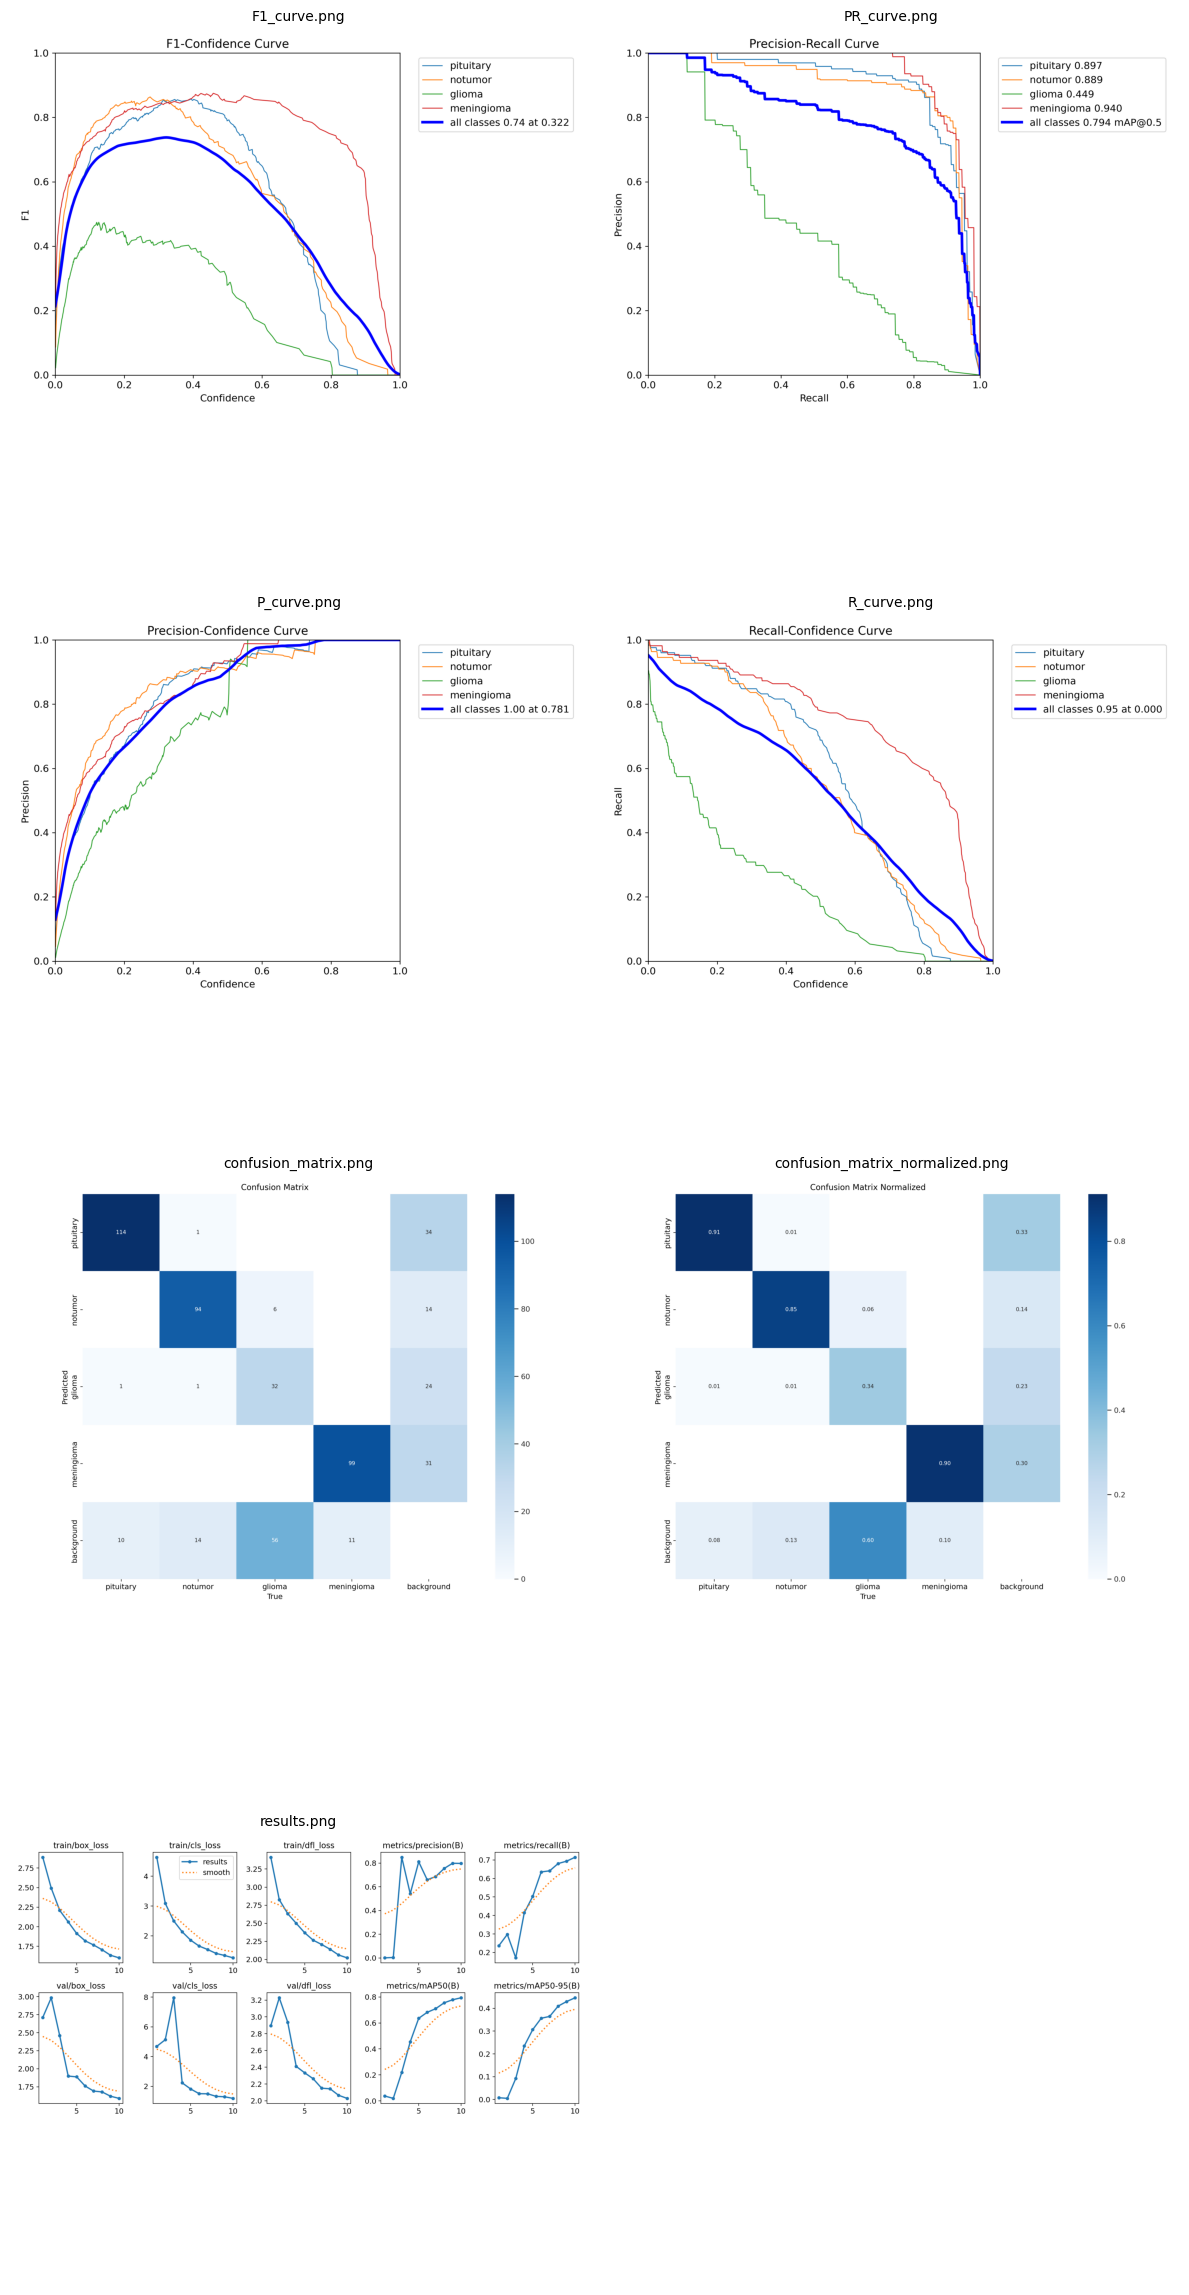

In [ ]:
#Calculate the number of rows required based on the total images and columns then showing the result
def plot_images(image_paths, columns=2):
    rows = math.ceil(len(image_paths) / columns)
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 6, rows * 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(image_paths):
            image_path = image_paths[i]
            if os.path.exists(image_path):
                img = mpimg.imread(image_path)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(os.path.basename(image_path), fontsize=10)
            else:
                ax.axis('off')
                ax.set_title(f"File not found: {os.path.basename(image_path)}", color='red', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


image_paths = [
    '/content/runs/detect/YOLOv8n/F1_curve.png',
    '/content/runs/detect/YOLOv8n/PR_curve.png',
    '/content/runs/detect/YOLOv8n/P_curve.png',
    '/content/runs/detect/YOLOv8n/R_curve.png',
    '/content/runs/detect/YOLOv8n/confusion_matrix.png',
    '/content/runs/detect/YOLOv8n/confusion_matrix_normalized.png',
    '/content/runs/detect/YOLOv8n/results.png',
]

plot_images(image_paths, columns=2)


# Testing

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('/content/runs/detect/YOLOv8n/weights/best.pt')

# Define the test directory
test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images'

# Perform predictions on each image
def predict_results_on_YOLOv8n(test_images_dir):
    import os
    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]
    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=512, conf=0.3)

predict_results_on_YOLOv8n(test_dir)



image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Tr-me_0033.jpg: 512x512 1 notumor, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 728.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Tr-me_0030.jpg: 512x512 1 notumor, 1 glioma, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 32.2ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Tr-me_0018.jpg: 512x512 1 notumor, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Tr-me_0015.jpg: 512x512 1 notumor

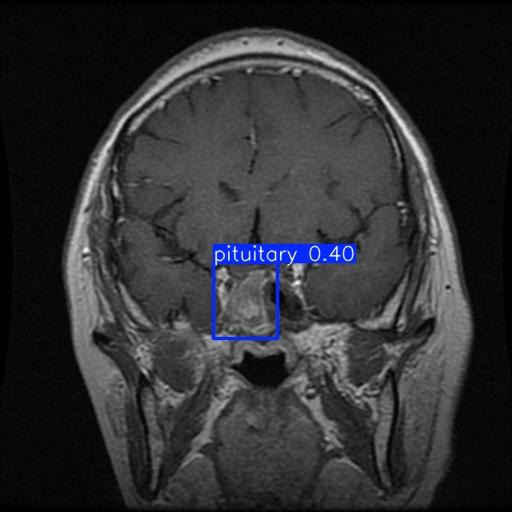

In [ ]:
#ptint a pic of testing result
from IPython.display import Image, display
display(Image(filename='runs/detect/predict/Tr-pi_0468.jpg'))


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve, auc
import numpy as np

def display_predicted_images(predicted_images_dir):
    """
    Display predicted images in a gallery inside the notebook.
    """
    # Get list of all image files in the predicted images directory
    image_files = [f for f in os.listdir(predicted_images_dir) if f.lower().endswith(('.jpg', '.png'))]

    # Set up the figure and axes for displaying the images
    num_images = len(image_files)
    cols = 3  # Number of columns for images
    rows = (num_images // cols) + (1 if num_images % cols else 0)  # Calculate number of rows

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten axes to make indexing easier

    # Display each image
    for i, image_file in enumerate(image_files):
        img = mpimg.imread(os.path.join(predicted_images_dir, image_file))
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_file)  # Set image file name as title

    # Hide any extra subplots if the number of images is less than the number of axes
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_pred):
    """
    Plot ROC curve with AUC score.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def generate_report(predicted_images_dir, y_true, y_pred):
    """
    Generate a report with predicted images and ROC curve.
    """
    # Display predicted images
    display_predicted_images(predicted_images_dir)

    # Plot ROC curve
    plot_roc_curve(y_true, y_pred)


# Example usage
predicted_images_dir = 'runs/detect/predict'

# Replace these with actual values based on your data
# y_true should be the actual labels (e.g., 0 for no tumor, 1 for tumor)
# y_pred should be the predicted probabilities or labels
y_true = np.array([0, 1, 0, 1])  # Actual labels (example)
y_pred = np.array([0.1, 0.9, 0.4, 0.8])  # Predicted probabilities (example)

# Generate the report
generate_report(predicted_images_dir, y_true, y_pred)
